In [1]:
import os
import time
import json
import copy
import pickle
import numpy as np
import pandas as pd

import sys
sys.path.append('../../GillesPy2/')
import gillespy2
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment, export_StochSS
from gillespy2 import TauHybridCSolver

import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
import ipywidgets as widgets
from IPython.display import display

# Devils DFTD 2-Stage Infection with Vaccination

## Read in observed data

In [2]:
# pop_data = pd.read_csv('../year_data/devil_data_v2.csv')
pop_data = pd.read_csv('../month_data/Devils_Dataset__Population_1985-2020.csv')

devil_pop = np.array(pop_data['Population'].iloc[:].values)

obs = np.vstack([devil_pop]).reshape(1, 1, -1)

In [3]:
dates = []
year = 1985
while len(dates) < 1001:
    for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]:
        dates.append(f"{month} {year}")
    year += 1

In [4]:
with open("./units_labels.json", "r") as ul_file:
    units_labels = json.load(ul_file)

## Model

In [5]:
class DevilsDFTD2StageInfectionWithVaccination(Model):
    def __init__(self, values=None):
        Model.__init__(self, name="Devils DFTD 2-Stage Infection with Vaccination")
        self.volume = 1

        # Parameters (Pre-Vaccination)
        birth_rate = Parameter(name="birth_rate", expression="0.055")
        death_rate_diseased = Parameter(name="death_rate_diseased", expression="0.048")
        death_rate_infected = Parameter(name="death_rate_infected", expression="0.03")
        death_rate_juvenile = Parameter(name="death_rate_juvenile", expression="0.006")
        death_rate_over_population = Parameter(name="death_rate_over_population", expression="2.3e-07")
        death_rate_susceptible = Parameter(name="death_rate_susceptible", expression="0.02335")
        incubation = Parameter(name="incubation", expression="22.6")
        infection_rate_diseased = Parameter(name="infection_rate_diseased", expression="3e-05")
        infection_rate_infected = Parameter(name="infection_rate_infected", expression="2e-05")
        maturity_rate = Parameter(name="maturity_rate", expression="0.04267")
        progression = Parameter(name="progression", expression="12")
        DFTD_introduction = Parameter(name="DFTD_introduction", expression="40")
        self.add_parameter([
            birth_rate, death_rate_diseased, death_rate_infected, death_rate_juvenile, death_rate_over_population,
            death_rate_susceptible, incubation, infection_rate_diseased, infection_rate_infected,
            maturity_rate, progression, DFTD_introduction
        ])
        
        # Parameters (Vaccination)
        vaccinated_infection_rate = Parameter(
            name="vaccinated_infection_rate", expression="0.6"
        )
        vaccination_proportion = Parameter(name="vaccination_proportion", expression="0.8")
        vaccine_frequency = Parameter(name="vaccine_frequency", expression="2")
        vaccine_start = Parameter(name="vaccine_start", expression="444")
        vaccine_time = Parameter(name="vaccine_time", expression="0")
        vacc_program_length = Parameter(name="vacc_program_length", expression="5")
        vacc_program_countdown = Parameter(name="vacc_program_countdown", expression="0")
        self.add_parameter([
            vaccinated_infection_rate, vaccination_proportion, vaccine_frequency, vaccine_start,
            vaccine_time, vacc_program_length, vacc_program_countdown
        ])
        
        # Variables (Pre-Vaccination)
        init_Devils_pop = round(devil_pop[0])
        init_J_pop = round(devil_pop[0] * 0.467)
        init_S_pop = round(devil_pop[0] - init_J_pop)
        
        Devils = Species(name="Devils", initial_value=init_Devils_pop, mode="discrete")
        Diseased = Species(name="Diseased", initial_value=0, mode="discrete")
        Exposed = Species(name="Exposed", initial_value=0, mode="discrete")
        Infected = Species(name="Infected", initial_value=0, mode="discrete")
        Juvenile = Species(name="Juvenile", initial_value=init_S_pop, mode="discrete")
        Susceptible = Species(name="Susceptible", initial_value=init_J_pop, mode="discrete")
        self.add_species([Devils, Diseased, Exposed, Infected, Juvenile, Susceptible])
        
        # Variables (Vaccination)
        Vaccinated = Species(name="Vaccinated", initial_value=0, mode="discrete")
        self.add_species(Vaccinated)
        
        # Reactions (Pre-Vaccination)
        Birth = Reaction(name="Birth",
            reactants={}, products={'Juvenile': 1, 'Devils': 1},
            propensity_function="birth_rate * (Susceptible + Exposed + Infected + Vaccinated)"
        )
        Mature = Reaction(name="Mature",
            reactants={'Juvenile': 1}, products={'Susceptible': 1},
            propensity_function="Juvenile * maturity_rate"
        )
        Death_Diseased = Reaction(name="Death_Diseased",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_diseased * Diseased"
        )
        Death_Diseased2 = Reaction(name="Death_Diseased2",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Diseased * (Devils - 1)"
        )
        Death_Exposed = Reaction(name="Death_Exposed",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_susceptible * Exposed"
        )
        Death_Exposed2 = Reaction(name="Death_Exposed2",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_over_population * Exposed * (Devils - 1)"
        )
        Death_Infected = Reaction(name="Death_Infected",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_infected * Infected"
        )
        Death_Infected2 = Reaction(name="Death_Infected2",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Infected * (Devils-1)"
        )
        Death_Juvenile = Reaction(name="Death_Juvenile",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_juvenile * Juvenile"
        )
        Death_Juvenile2 = Reaction(name="Death_Juvenile2",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Juvenile * (Devils-1)"
        )
        Death_Susceptible = Reaction(name="Death_Susceptible",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_susceptible * Susceptible"
        )
        Death_Susceptible2 = Reaction(name="Death_Susceptible2",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Susceptible * (Devils-1)"
        )
        DFTD_Stage1 = Reaction(name="DFTD_Stage1",
            reactants={'Exposed': 1}, products={'Infected': 1},
            propensity_function="Exposed / incubation"
        )
        DFTD_Stage2 = Reaction(name="DFTD_Stage2",
            reactants={'Infected': 1}, products={'Diseased': 1},
            propensity_function="Infected / progression"
        )
        TransmissionD = Reaction(name="TransmissionD",
            reactants={'Susceptible': 1, 'Diseased': 1}, products={'Exposed': 1, 'Diseased': 1},
            propensity_function="infection_rate_diseased * Susceptible * Diseased"
        )
        TransmissionI = Reaction(name="TransmissionI",
            reactants={'Susceptible': 1, 'Infected': 1}, products={'Exposed': 1, 'Infected': 1},
            propensity_function="infection_rate_infected * Susceptible * Infected"
        )
        self.add_reaction([
            Birth, Mature, Death_Diseased, Death_Diseased2, Death_Exposed, Death_Exposed2, Death_Infected,
            Death_Infected2, Death_Juvenile, Death_Juvenile2, Death_Susceptible, Death_Susceptible2,
            DFTD_Stage1, DFTD_Stage2, TransmissionD, TransmissionI
        ])
        
        # Reactions (Vaccination)
        Vaccine_Failure_I = Reaction(name="Vaccine_Failure_I",
            reactants={'Vaccinated': 1, 'Infected': 1}, products={'Exposed': 1, 'Infected': 1},
            propensity_function="infection_rate_infected * vaccinated_infection_rate * Vaccinated * Infected / \
                                        (Susceptible + Exposed + Infected + Vaccinated + Diseased + Juvenile)"
        )
        Vaccine_Failure_D = Reaction(name="Vaccine_Failure_D",
            reactants={'Vaccinated': 1, 'Diseased': 1}, products={'Exposed': 1, 'Diseased': 1},
            propensity_function="infection_rate_diseased * vaccinated_infection_rate * Vaccinated * Diseased / \
                                        (Susceptible + Exposed + Infected + Vaccinated + Diseased + Juvenile)"
        )
        Death_Vaccinated = Reaction(name="Death_Vaccinated",
            reactants={'Devils': 1, 'Vaccinated': 1}, products={},
            propensity_function="death_rate_susceptible * Vaccinated"
        )
        Death_Vaccinated2 = Reaction(name="Death_Vaccinated2",
            reactants={'Devils': 1, 'Vaccinated': 1}, products={},
            propensity_function="death_rate_over_population * Vaccinated * (Devils - 1)"
        )
        self.add_reaction([Vaccine_Failure_I, Vaccine_Failure_D, Death_Vaccinated, Death_Vaccinated2])
        
        # Event Triggers
        DFTD_Introduction_trig = EventTrigger(
            expression="t >= DFTD_introduction",initial_value=False, persistent=False
        )
        Vaccination_Start_trig = EventTrigger(
            expression="t >= vaccine_start and vacc_program_length > 0", initial_value=False, persistent=True
        )
        Vaccination_trig = EventTrigger(
            expression="t >= vaccine_time and vacc_program_countdown > 0", initial_value=False, persistent=True
        )

        # Event Assignments
        DFTD_Introduction_assign_1 = EventAssignment(variable="Infected", expression="1")
        DFTD_Introduction_assign_2 = EventAssignment(variable="Susceptible", expression="Susceptible - 1")
        Vaccination_Start_assign_1 = EventAssignment(
            variable="vaccine_time", expression="vaccine_start + 12 / vaccine_frequency"
        )
        Vaccination_Start_assign_2 = EventAssignment(
            variable="vacc_program_countdown",
            expression="(12 * vacc_program_length) - (12 / vaccine_frequency)"
        )
        Vaccination_assign_1 = EventAssignment(
            variable="vaccine_time", expression="vaccine_time + 12 / vaccine_frequency"
        )
        Vaccination_assign_2 = EventAssignment(
            variable="vacc_program_countdown", expression="vacc_program_countdown - (12 / vaccine_frequency)"
        )
        Vaccination_assign_3 = EventAssignment(
            variable="Vaccinated", expression="Vaccinated + (Susceptible * vaccination_proportion)"
        )
        Vaccination_assign_4 = EventAssignment(
            variable="Susceptible", expression="Susceptible * (1 - vaccination_proportion)"
        )

        # Events
        DFTD_Introduction = Event(
            name="DFTD_Introduction", trigger=DFTD_Introduction_trig, use_values_from_trigger_time=False,
            assignments=[DFTD_Introduction_assign_1, DFTD_Introduction_assign_2], delay=None, priority="0"
        )
        Vaccination_Start = Event(
            name="Vaccination_Start", trigger=Vaccination_Start_trig, delay=None, priority="1", 
            use_values_from_trigger_time=True,
            assignments=[Vaccination_Start_assign_1, Vaccination_Start_assign_2,
                         Vaccination_assign_3, Vaccination_assign_4]
        )
        Vaccination_Program = Event(
            name="Vaccination_Event", trigger=Vaccination_trig, delay=None, priority="2", 
            use_values_from_trigger_time=True, assignments=[
                Vaccination_assign_1, Vaccination_assign_2, Vaccination_assign_3, Vaccination_assign_4
            ]
        )
        self.add_event(DFTD_Introduction)
        self.add_event(Vaccination_Start)
        self.add_event(Vaccination_Program)

        # Timespan
        self.timespan(np.arange(0, 1001, 1))
        
    def run(self, **kwargs):
        results = super().run(**kwargs)
        while results['Infected'][300] <= 0:
            results = super().run(**kwargs)
        return results

## Simulation

In [6]:
class Simulation:
    def __init__(self, model, kwargs=None, variables=None):
        self.result = None
        self.variables = variables
        self.model = model
        self.kwagrs = kwargs
        self.dftd_eradiction = None
        self.devil_extinction = None
    
    def __run_vaccine_period(self, resume, t, args):
        if 'vaccination_proportion' in args['variables']:
            vaccination_proportion = args['variables']['vaccination_proportion']
        else:
            vaccination_proportion = self.model.listOfParameters['vaccination_proportion'].value
        sus_pop = resume[0]['Susceptible'][-1]
        vacc_pop = resume[0]['Vaccinated'][-1]
        new_vacc_pop = int(sus_pop * vaccination_proportion)
        args['variables']['Vaccinated'] = int(vacc_pop + new_vacc_pop)
        args['variables']['Susceptible'] = int(sus_pop - new_vacc_pop)
        return self.model.run(resume=resume, t=t, **args)
    
    def compute_dftd_devils_eradication_prob(self, verbose=True, return_prob=False):
        if verbose: print(self.variables)
        if self.dftd_eradiction is not None and self.devil_extinction is not None:
            if return_prob:
                return self.dftd_eradiction, self.devil_extinction
            else:
                print(f"DFTD elimination: {self.dftd_eradiction}%")
                print(f"Devil extinction: {self.devil_extinction}%")
                return
        ext_count = 0
        erd_count = 0
        for i in range(100):
            if verbose: print(".", end='')
            if self.kwargs is None:
                self.configure()
            result = self.run(return_results=True)
            Dftd = result['Infected'] + result['Exposed'] + result['Diseased']
            if min(Dftd[400:]) == 0.0:
                erd_count += 1
            Devils = Dftd + result['Juvenile'] + result['Susceptible'] + result['Vaccinated']
            if min(Devils[400:]) == 0.0:
                ext_count += 1
        self.dftd_eradiction = erd_count
        self.devil_extinction = ext_count
        if return_prob:
            return erd_count, ext_count
        else:
            if verbose: print()
            print(f"DFTD elimination: {erd_count}%")
            print(f"Devil extinction: {ext_count}%")
    
    def configure(self):
        solver = TauHybridCSolver(model=model, variable=True)
        self.kwargs = {
            "solver": solver,
            "number_of_trajectories": 1,
        }
    
    def plot(self, start=0, alpha=0.3, plot_observed=False):
        carry_cap = int(max(devil_pop)*1.16)
        dftd_start = int(self.result.model.listOfParameters['DFTD_introduction'].value)
        if self.variables is not None and "vaccine_start" in self.variables.keys():
            vaccine_start = self.variables['vaccine_start']
        else:
            vaccine_start = int(self.result.model.listOfParameters['vaccine_start'].value)
            
        if self.variables is None or 'program_length' not in self.variables:
            vacc_program_length = self.result.model.listOfParameters['vacc_program_length'].value
            vaccine_end = vaccine_start + 12 * int(vacc_program_length)
        else:
            vaccine_end = vaccine_start + 12 * int(self.variables['vacc_program_length'])

        spec_list = [self.result['Juvenile'], self.result['Susceptible'], self.result['Exposed'],
                     self.result['Infected'], self.result['Diseased'], self.result['Vaccinated']]
        total_devils = np.add.reduce(spec_list)
        x = self.result['time'][start:]
        text_offset = (self.result['time'].size - start) / 601
        
        fig, ax1 = plt.subplots(figsize=[15, 8])
        plt.title("Tasmanian Devil Population with DFTD: Vaccination Program", fontsize=18)
        ax1.set_xlabel(f"Time (months) since {dates[start]}", fontsize=14)
        ax1.set_ylabel("Population of Tasmanian Devils", fontsize=14)
        ax1.plot(x, total_devils[start:], color='blue', label='Total Devils')
        ax1.plot(x, self.result['Juvenile'][start:], color='purple', alpha=alpha, label='Juvenile')
        ax1.plot(x, self.result['Susceptible'][start:], color='green', alpha=alpha, label='Susceptible')
        ax1.plot(x, self.result['Exposed'][start:], color='magenta', alpha=alpha, label='Exposed')
        ax1.plot(x, self.result['Infected'][start:], color='red', alpha=alpha, label='Infected')
        ax1.plot(x, self.result['Diseased'][start:], color='brown', alpha=alpha, label='Diseased')
        
        if plot_observed:
            ax1.plot(range(len(devil_pop)), devil_pop, '--k', label='Observed')
        
        # DFTD Introduction
        if start <= dftd_start:
            ax1.plot([dftd_start, dftd_start], [-3000, carry_cap], '--k', alpha=0.3)
            ax1.text(dftd_start - 10 * text_offset, 45000, "DFTD Introduced",
                     rotation="vertical", color="black", fontsize=12)
            ax1.text(dftd_start + 3 * text_offset, 48000, dates[dftd_start],
                     rotation="vertical", color="black", fontsize=12)
        
        # Vaccination
        if vaccine_start < vaccine_end:
            ax1.plot(x, self.result['Vaccinated'][start:], color='cyan', alpha=alpha, label='Vaccinated')
            ax1.plot([vaccine_start, vaccine_start], [-3000, carry_cap - 3000], '--k', alpha=0.3)
            ax1.plot([vaccine_end, vaccine_end], [-3000, carry_cap - 3000], '--k', alpha=0.3)
            ax1.plot([vaccine_start, vaccine_end], [carry_cap - 3000, carry_cap - 3000], '--k', alpha=0.3)
            ax1.text(vaccine_start, carry_cap - 2300, f"Vaccine: {dates[vaccine_start]} - {dates[vaccine_end]}",
                     color="black", fontsize=12)
            
        ax1.set_ylim(-3000, carry_cap)
        ax1.set_xlim(-5, 1005)
        ax1.tick_params(axis='x', labelsize=12)
        ax1.tick_params(axis='y',labelsize=12, labelrotation=90)
        ax1.legend(loc='upper right', fontsize=12)
        fig.tight_layout()
    
    def run(self, return_results=False, use_existing_results=False):
        if self.result is not None and use_existing_results:
            return
                
        result = self.model.run(**self.kwargs)
        if return_results:
            return result
        else:
            self.result = result

#         run_args = copy.deepcopy(self.kwargs)
#         if "variables" not in run_args:
#             orig_vars = {}
#             run_args['variables'] = {}
#         else:
#             orig_vars = copy.deepcopy(run_args['variables'])

#         # Run Pre-infection Period
#         self.model.resolve_parameters()
#         if 'DFTD_introduction' in run_args['variables']:
#             dfdt_intro = run_args['variables']['DFTD_introduction']
#         else:
#             dfdt_intro = self.model.listOfParameters['DFTD_introduction'].value
#         res1 = self.model.run(**run_args, t=dfdt_intro - 1)

#         # Configure Infection Period
#         run_args['variables']['Infected'] = "1"
#         run_args['variables']['Susceptible'] = f"{int(res1[0]['Susceptible'][-1] - 1)}"
#         if 'vaccine_time' in run_args['variables']:
#             vaccine_time = run_args['variables']['vaccine_time']
#         else:
#             vaccine_time = self.model.listOfParameters['vaccine_time'].value

#         # Run Infection Period
#         prog_start = 444 + vaccine_time
#         result = self.model.run(resume=res1, t=prog_start, **run_args)
#         while result['Infected'][-1] <= 0:
#             result = self.model.run(resume=res1, t=prog_start - 1, **run_args)

#         # Configure Vaccination Period
#         if 'vaccine_frequency' in run_args['variables']:
#             vaccine_frequency = run_args['variables']['vaccine_frequency']
#         else:
#             vaccine_frequency = self.model.listOfParameters['vaccine_frequency'].value
#         if 'program_length' in run_args['variables']:
#             program_length = run_args['variables']['program_length']
#         else:
#             program_length = self.model.listOfParameters['program_length'].value

#         # Run Vaccination Period
#         prog_inter = 12 / vaccine_frequency
#         prog_end = prog_start + program_length * 12
#         t = prog_start
#         while t < prog_end:
#             t += prog_inter
#             run_args['variables'] = orig_vars
#             result = self.__run_vaccine_period(result, t - 1, run_args)
#             if "Vaccinated" in orig_vars:
#                 del orig_vars['Vaccinated']
#                 del orig_vars['Susceptible']

#         run_args['variables'] = orig_vars
#         res4 = self.model.run(resume=result, **run_args)
#         if return_results:
#             return res4
#         else:
#             self.result = res4

## Parameter Sweep Job

In [7]:
class ParameterSweep():
    def __init__(self, model, params):
        self.model = model
        self.params = params
        self.results = {}

    def __get_result_key(self, variables):
        elements = []
        for name, value in variables.items():
            elements.append(f"{name}:{value}")
        return ",".join(elements)

    def __run(self, index, variables, verbose):
        if index < len(self.params):
            param = self.params[index]
            index += 1
            for val in param['range']:
                variables[param['parameter']] = val
                self.__run(index=index, variables=variables, verbose=verbose)
        else:
            result_key = self.__get_result_key(variables=variables)
            if verbose:
                message = f'running: {result_key.replace(":", "=").replace(",", ", ")}'
                print(message)
            tmp_sim = Simulation(model=self.model, variables=copy.deepcopy(variables))
            tmp_sim.configure()
            tmp_sim.kwargs['variables'] = variables
            tmp_sim.run()
            self.results[result_key] = tmp_sim

    def build_layout(self, ai_widgets):
        ai_widgets = list(ai_widgets.values())
        hbs = []
        for i in range(0, len(ai_widgets), 4):
            hb_list = [ai_widgets[i], ai_widgets[i+1]]
            if len(ai_widgets) >= i+3:
                hb_list.extend([ai_widgets[i+2], ai_widgets[i+3]])
            hbs.append(widgets.HBox(hb_list, layout=self.get_layout()))
        return widgets.VBox(hbs, layout=self.get_layout(vertical=True))
    
    def build_widgets(self):
        param_names = units_labels['w_labels']
        ai_widgets = {}
        for i, param in enumerate(self.params):
            fs = widgets.SelectionSlider(
                options=param['range'], value=param['range'][0], description=param_names[param['parameter']]
            )
            ai_widgets[f'fs{i}'] = fs
            cs = widgets.Checkbox(value=False, description='Fixed')
            ai_widgets[f'cs{i}'] = cs
        return ai_widgets
    
    def configure(self, **widget_args):
        sim_key = []
        for i in range(0, len(widget_args), 2):
            param_key = int(i/2)
            sim_key.append(f"{self.params[param_key]['parameter']}:{list(widget_args.values())[i]}")
        sim_key = ",".join(sim_key)
        
        self.results[sim_key].plot(plot_observed=self.plot_observed)
        
        params, fixed = self.display_details(widget_args)

        if len(params) < 1:
            print("At least 1 fixed parameters are required")
        elif len(params) > 2:
            print("There are too many fixed parameters")
        elif len(params) == 2:
            base_key = self.get_base_key(list(widget_args.values())[::2], params)
            dftd, devils = self.get_plot_data(params, base_key)
            self.display_plots(params, dftd, devils)
        else:
            labels = units_labels['labels']
            units = units_labels['units']
            param = params[0]
            self.plot_devil_dftd_extinction_over_param(
                res_sub_keys=fixed, key=param['parameter'], param_label=labels[param['parameter']],
                units=units[param['parameter']]
            )
    
    def display_details(self, args, verbose=False):
        params = []
        fixed = []
        values = list(args.values())
        for i in range(0, len(values), 2):
            index = int(i/2)
            if values[i + 1]:
                fixed.append(f"{self.params[index]['parameter']}: {values[i]}")
            else:
                params.append(self.params[index])
        if fixed and verbose:
            print(", ".join(fixed))
        return params, [param.replace(": ", ":") for param in fixed]
    
    def display_plots(self, params, dftd, devils):
        labels = units_labels['labels']
        units = units_labels['units']
        x_units = units[params[0]['parameter']]
        if x_units:
            x_units = f" ({x_units})"
        y_units = units[params[1]['parameter']]
        if y_units:
            y_units = f" ({y_units})"
        x_label = f"{labels[params[0]['parameter']]}{x_units}"
        y_label = f"{labels[params[1]['parameter']]}{y_units}"
        dftd = np.flip(dftd, 0)
        devils = np.flip(devils, 0)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 6])

        im1 = ax1.imshow(dftd)
        ax1.set_xticks(np.arange(len(dftd[0])))
        ax1.set_xticklabels(labels=params[0]['range'])
        ax1.set_yticks(np.arange(len(dftd)))
        ax1.set_yticklabels(labels=np.flip(params[1]['range']))
        ax1.set_xlabel(x_label, fontsize=14)
        ax1.set_ylabel(y_label, fontsize=14)
        ax1.tick_params(axis="x", labelsize=12, labelrotation=90)
        ax1.tick_params(axis="y", labelsize=12)
        ax1.set_title('Probability of DFTD Elimination', fontsize=14)
        ax1.figure.colorbar(im1, ax=ax1)
        for i in range(len(dftd)):
            for j in range(len(dftd[0])):
                _ = ax1.text(j, i, f"{dftd[i, j]}%", ha="center", va="center", color="w", fontsize=12)

        im2 = ax2.imshow(devils)
        ax2.set_xticks(np.arange(len(devils[0])))
        ax2.set_xticklabels(labels=params[0]['range'])
        ax2.set_yticks(np.arange(len(devils)))
        ax2.set_yticklabels(labels=np.flip(params[1]['range']))
        ax2.set_xlabel(x_label, fontsize=14)
        ax2.set_ylabel(y_label, fontsize=14)
        ax2.tick_params(axis="x", labelsize=12, labelrotation=90)
        ax2.tick_params(axis="y", labelsize=12)
        ax2.set_title('Probability of Devil Extinction', fontsize=14)
        ax2.figure.colorbar(im2, ax=ax2)
        for i in range(len(devils)):
            for j in range(len(devils[0])):
                _ = ax2.text(j, i, f"{devils[i, j]}%", ha="center", va="center", color="w", fontsize=12)
    
    def explore_results(self, plot_observed=False):
        self.plot_observed = plot_observed
        ai_widgets = self.build_widgets()
        ui = self.build_layout(ai_widgets)
        out = interactive_output(self.configure, ai_widgets)
        display(ui, out)
    
    def get_base_key(self, values, params):
        base_key = []
        for i, param in enumerate(self.params):
            if param in params:
                base_key.append("__param2__" if "__param1__" in base_key else "__param1__")
            else:
                base_key.append(f"{param['parameter']}:{values[i]}")
        return ",".join(base_key)
    
    def get_layout(self, vertical=False):
        kwargs = {
            "margin": '0px 10px 10px 0px',
            "padding": '5px 5px 5px 5px'
        }
        if vertical:
            kwargs['border'] = 'solid 1px red'
        return widgets.Layout(**kwargs)
    
    def get_plot_data(self, params, base_key):
        dftd = []
        devils = []
        for value1 in params[1]['range']:
            _key = base_key.replace("__param2__", f"{params[1]['parameter']}:{value1}")
            inner_dftd = []
            inner_devils = []
            for value2 in params[0]['range']:
                key = _key.replace("__param1__", "{0}:{1}".format(params[0]['parameter'], value2))
                dftd_prob, devil_prob = self.results[key].compute_dftd_devils_eradication_prob(verbose=False,
                                                                                               return_prob=True)
                inner_dftd.append(dftd_prob)
                inner_devils.append(devil_prob)
            dftd.append(inner_dftd)
            devils.append(inner_devils)
        return np.array(dftd), np.array(devils)
    
    def plot_devil_dftd_extinction_over_param(self, res_sub_keys=[], key="vacc_program_length",
                                              param_label="Vaccine Program Length", units="years"):
        if len(self.params) < 2:
            sims = self.results.values()
        elif (len(self.params) - len(res_sub_keys)) != 1:
            raise Exception(f"res_sub_keys[{len(self.params)}] must be set.")
        else:
            _keys = list(self.results.keys())
            keys = []
            for sub_key in res_sub_keys:
                for res_key in _keys:
                    if sub_key in res_key.split(","):
                        keys.append(res_key)
            sims = [self.results[key] for key in keys]
            
        pl_values = []
        pl_ext_rate = []
        pl_erd_rate = []
        for sim in sims:
            pl_values.append(sim.variables[key])
            dftd_prob, devil_prob = sim.compute_dftd_devils_eradication_prob(verbose=False,
                                                                             return_prob=True)
            pl_ext_rate.append(devil_prob)
            pl_erd_rate.append(dftd_prob)
            
        units = "" if units is None else f" ({units})"
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 6])
        
        im1 = ax1.plot(pl_values, pl_erd_rate)
        ax1.set_title(f'Dftd elimination vs. {param_label}', fontsize=14)
        ax1.set_ylim(ymin=-1,ymax=100)
        ax1.tick_params(axis="x", labelsize=12)
        ax1.tick_params(axis="y", labelsize=12)
        ax1.set_xlabel(f"{param_label}{units}", fontsize=14)
        ax1.set_ylabel("DFTD elimination probability", fontsize=14)
        
        im2 = ax2.plot(pl_values, pl_ext_rate)
        ax2.set_title(f'Devil extinction vs. {param_label}', fontsize=14)
        ax2.set_ylim(ymin=-1,ymax=100)
        ax2.tick_params(axis="x", labelsize=12)
        ax2.tick_params(axis="y", labelsize=12)
        ax2.set_xlabel(f"{param_label}{units}", fontsize=14)
        ax2.set_ylabel("Devil extinction probability", fontsize=14)

    def run(self, verbose=False, use_existing_results=False):
        if self.results and use_existing_results:
            return
        index = 0
        variables = {}
        self.__run(index=index, variables=variables, verbose=verbose)

## Load existing state

In [8]:
state_path = "./DevilsDFTD2StageInfectionWithVaccinationState.p"
if os.path.exists(state_path):
    with open(state_path, "rb") as state_file:
        nb_state = pickle.load(state_file)
else:
    nb_state = None
    print("No existing state found.")

No existing state found.


## Run Simulation with default parameters

In [9]:
if nb_state is None:
    model = DevilsDFTD2StageInfectionWithVaccination()
else:
    model = nb_state['model']

In [10]:
if nb_state is None:
    sim = Simulation(model=model)
else:
    sim = nb_state['sim']

In [11]:
sim.configure()
%time sim.run(use_existing_results=True)

CPU times: user 4.54 ms, sys: 2.6 ms, total: 7.14 ms
Wall time: 1.34 s


## Visualization

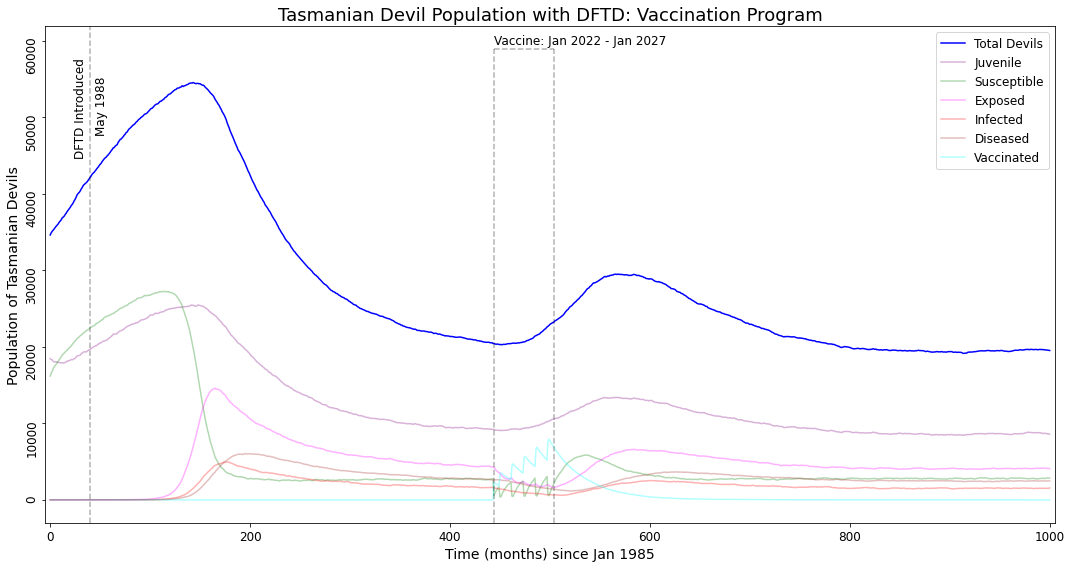

In [12]:
sim.plot()

In [ ]:
%time sim.compute_dftd_devils_eradication_prob(verbose=False)

## Run Parameter Sweep Job

In [ ]:
if nb_state is None:
    params = [
        {"parameter": "vacc_program_length", "range": [3, 6, 9, 12, 15]},
        {"parameter": "vaccine_frequency", "range": [1, 2, 3, 4, 6, 12]}
    ]
    job = ParameterSweep(model=model, params=params)
else:
    job = nb_state['job']

In [ ]:
%time job.run(use_existing_results=True)

## Visualization

In [ ]:
if nb_state is None:
    tic=time.time()
    for vpl in params[0]['range']:
        res_sub_keys = [f"vacc_program_length:{vpl}"]
        job.plot_devil_dftd_extinction_over_param(res_sub_keys=res_sub_keys)
        print(".", end="")
    print(f"simulation complete in {time.time()-tic:.2f}s")

In [ ]:
%time job.plot_devil_dftd_extinction_over_param(res_sub_keys=["vaccine_frequency:6"])

In [ ]:
%time job.explore_results()

## Store notebook state

In [ ]:
nb_state = {"model": model, "sim":sim, "job":job}
with open(state_path, "wb") as state_file:
    pickle.dump(nb_state, state_file)